##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Simple audio recognition: Recognizing keywords

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/audio/simple_audio">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/audio/simple_audio.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/audio/simple_audio.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/audio/simple_audio.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to preprocess audio files in the WAV format and build and train a basic [automatic speech recognition](https://en.wikipedia.org/wiki/Speech_recognition) (ASR) model for recognizing ten different words. You will use a portion of the [Speech Commands dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) ([Warden, 2018](https://arxiv.org/abs/1804.03209)), which contains short (one-second or less) audio clips of commands, such as "down", "go", "left", "no", "right", "stop", "up" and "yes".

Real-world speech and audio recognition [systems](https://ai.googleblog.com/search/label/Speech%20Recognition) are complex. But, like [image classification with the MNIST dataset](../quickstart/beginner.ipynb), this tutorial should give you a basic understanding of the techniques involved.

## Setup

Import necessary modules and dependencies. You'll be using `tf.keras.utils.audio_dataset_from_directory` (introduced in TensorFlow 2.10), which helps generate audio classification datasets from directories of `.wav` files. You'll also need [seaborn](https://seaborn.pydata.org) for visualization in this tutorial.

In [2]:
!pip install -U -q tensorflow tensorflow_datasets


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [3]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

2025-02-26 06:29:42.254467: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-26 06:29:42.258234: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-26 06:29:42.269146: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740547782.287608   44495 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740547782.293140   44495 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Import the mini Speech Commands dataset

To save time with data loading, you will be working with a smaller version of the Speech Commands dataset. The [original dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) consists of over 105,000 audio files in the [WAV (Waveform) audio file format](https://www.aelius.com/njh/wavemetatools/doc/riffmci.pdf) of people saying 35 different words. This data was collected by Google and released under a CC BY license.

Download and extract the `mini_speech_commands.zip` file containing the smaller Speech Commands datasets with `tf.keras.utils.get_file`:

In [4]:
DATASET_PATH = 'data/mini_speech_commands_extracted/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

The dataset's audio clips are stored in eight folders corresponding to each speech command: `no`, `yes`, `down`, `go`, `left`, `up`, `right`, and `stop`:

In [5]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['stop' 'down' 'left' 'go' 'up' 'no' 'yes' 'right']


Divided into directories this way, you can easily load the data using `keras.utils.audio_dataset_from_directory`. 

The audio clips are 1 second or less at 16kHz. The `output_sequence_length=16000` pads the short ones to exactly 1 second (and would trim longer ones) so that they can be easily batched.

In [6]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.

label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


W0000 00:00:1740547784.771554   44495 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of `(batch, samples, channels)`. 

In [7]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

This dataset only contains single channel audio, so use the `tf.squeeze` function to drop the extra axis:

In [8]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

The `utils.audio_dataset_from_directory` function only returns up to two splits. It's a good idea to keep a test set separate from your validation set.
Ideally you'd keep it in a separate directory, but in this case you can use `Dataset.shard` to split the validation set into two halves. Note that iterating over **any** shard will load **all** the data, and only keep its fraction. 

In [9]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [10]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


2025-02-26 06:29:45.082539: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Let's plot a few audio waveforms:

In [11]:
label_names[[1,1,3,0]]

array(['go', 'go', 'no', 'down'], dtype='<U5')

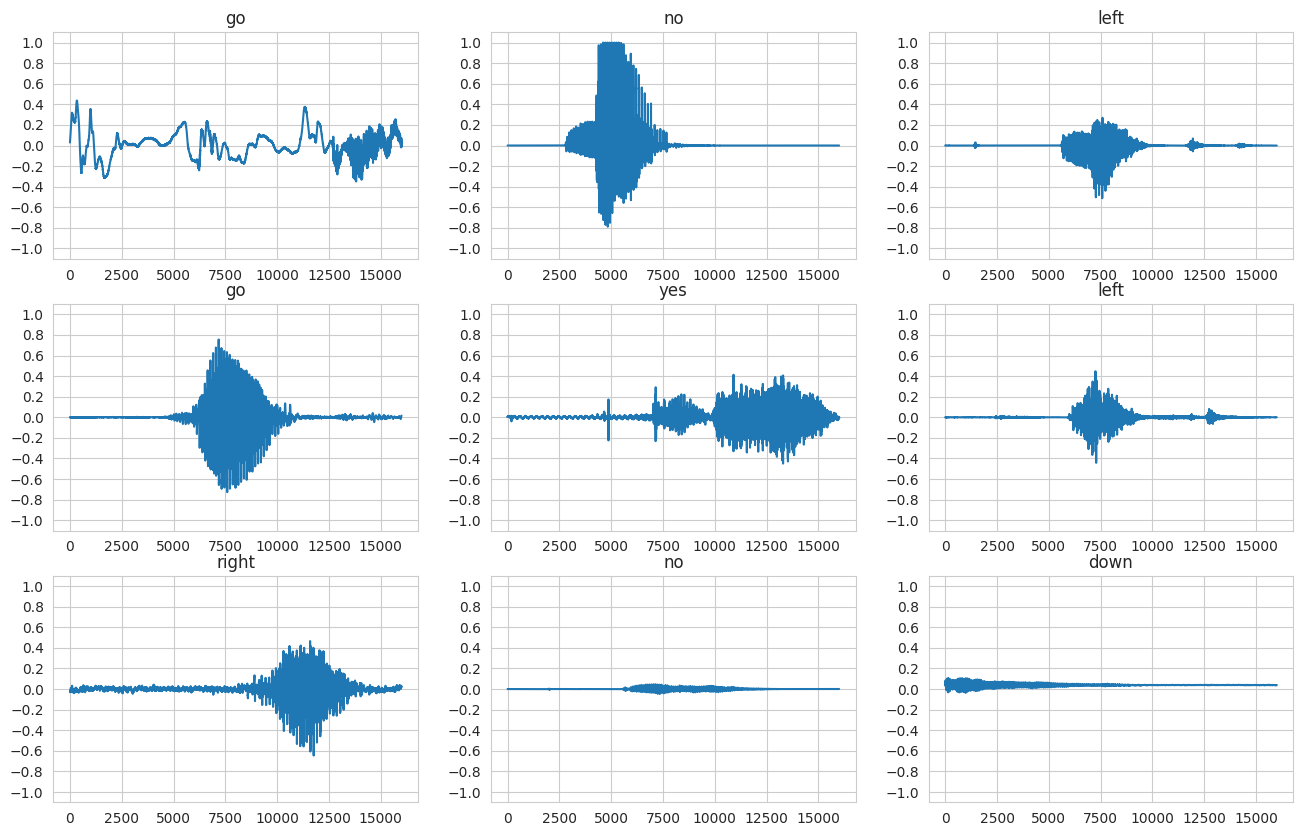

In [12]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

## Convert waveforms to spectrograms

The waveforms in the dataset are represented in the time domain. Next, you'll transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the [short-time Fourier transform (STFT)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) to convert the waveforms to as [spectrograms](https://en.wikipedia.org/wiki/Spectrogram), which show frequency changes over time and can be represented as 2D images. You will feed the spectrogram images into your neural network to train the model.

A Fourier transform (`tf.signal.fft`) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (`tf.signal.stft`) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

Create a utility function for converting waveforms to spectrograms:

- The waveforms need to be of the same length, so that when you convert them to spectrograms, the results have similar dimensions. This can be done by simply zero-padding the audio clips that are shorter than one second (using `tf.zeros`).
- When calling `tf.signal.stft`, choose the `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on the STFT parameters choice, refer to [this Coursera video](https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe) on audio signal processing and STFT.
- The STFT produces an array of complex numbers representing magnitude and phase. However, in this tutorial you'll only use the magnitude, which you can derive by applying `tf.abs` on the output of `tf.signal.stft`.

In [13]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

Next, start exploring the data. Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio:

In [14]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: go
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Now, define a function for displaying a spectrogram:

In [15]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

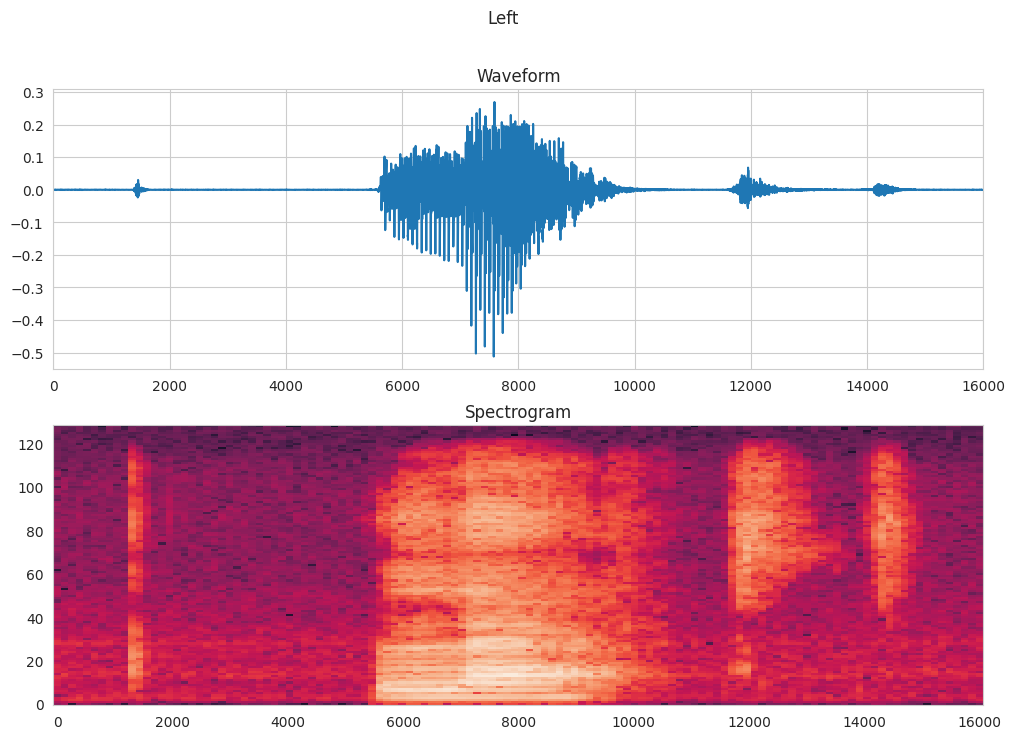

In [16]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Now, create spectrogram datasets from the audio datasets:

In [17]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [18]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Examine the spectrograms for different examples of the dataset:

In [19]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

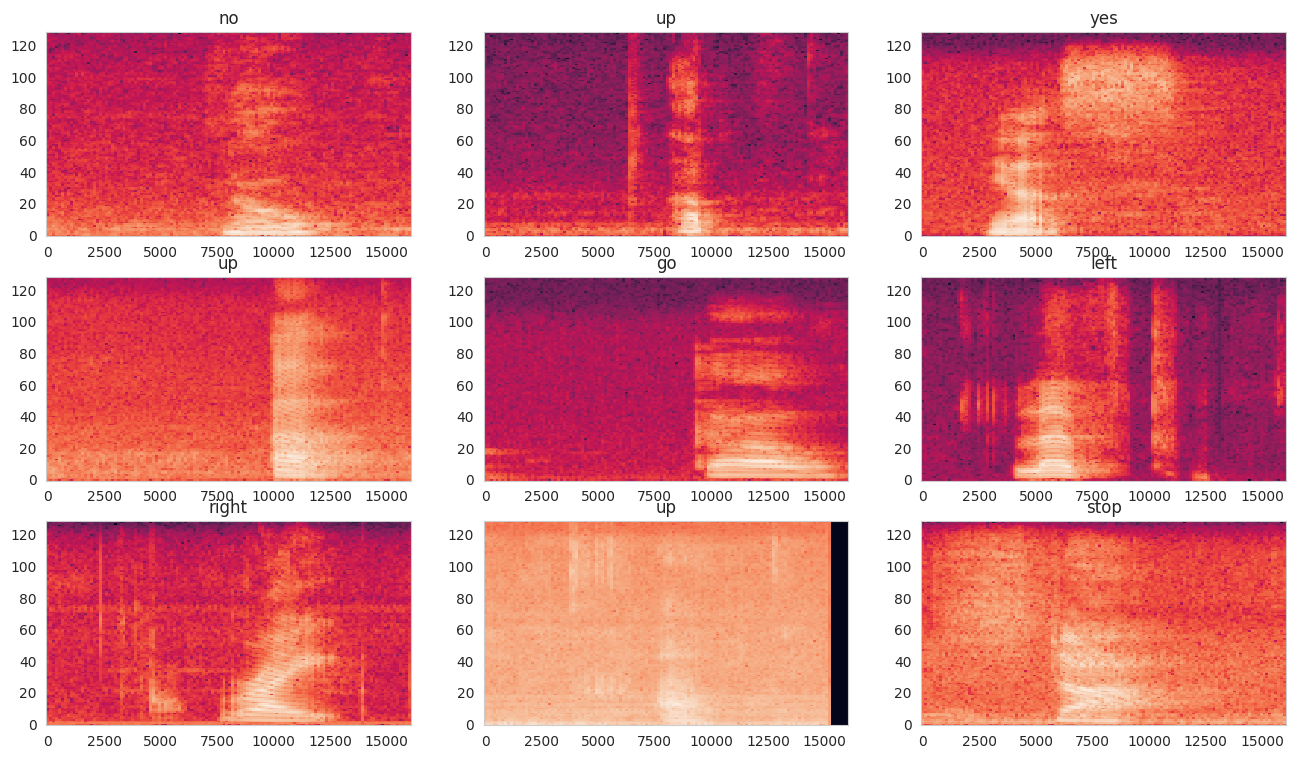

In [20]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

## Build and train the model

Add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [21]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images.

Your `tf.keras.Sequential` model will use the following Keras preprocessing layers:

- `tf.keras.layers.Resizing`: to downsample the input to enable the model to train faster.
- `tf.keras.layers.Normalization`: to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (that is, the mean and the standard deviation).

In [22]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,611 (6.20 MB)

 Trainable params: 1,625,608 (6.20 MB)

 Non-trainable params: 3 (16.00 B)

Configure the Keras model with the Adam optimizer and the cross-entropy loss:

In [23]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Train the model over 10 epochs for demonstration purposes:

In [24]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10


I0000 00:00:1723794456.367614  244224 service.cc:146] XLA service 0x7f52d4004720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1723794456.367645  244224 service.cc:154]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1723794456.367649  244224 service.cc:154]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1723794456.367651  244224 service.cc:154]   StreamExecutor device (2): Tesla T4, Compute Capability 7.5
I0000 00:00:1723794456.367654  244224 service.cc:154]   StreamExecutor device (3): Tesla T4, Compute Capability 7.5


  1/100 ━━━━━━━━━━━━━━━━━━━━ 6:09 4s/step - accuracy: 0.1250 - loss: 2.1091

 10/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1459 - loss: 2.1154 

 19/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1719 - loss: 2.0914

 28/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1942 - loss: 2.0681

I0000 00:00:1723794458.966081  244224 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 37/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2122 - loss: 2.0463

 46/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2280 - loss: 2.0235

 55/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2417 - loss: 2.0011

 64/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2534 - loss: 1.9805

 73/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2635 - loss: 1.9620

 82/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2732 - loss: 1.9440

 91/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2823 - loss: 1.9262

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2908 - loss: 1.9090

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.2918 - loss: 1.9072 - val_accuracy: 0.5990 - val_loss: 1.3176


Epoch 2/10


  1/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5938 - loss: 1.4221

 10/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5510 - loss: 1.3988 

 19/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5442 - loss: 1.3676

 28/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5454 - loss: 1.3431

 37/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5477 - loss: 1.3263

 46/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5493 - loss: 1.3132

 55/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5514 - loss: 1.3018

 64/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5536 - loss: 1.2921

 73/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5560 - loss: 1.2826

 82/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5585 - loss: 1.2735

 91/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5606 - loss: 1.2654

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5626 - loss: 1.2580

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5629 - loss: 1.2572 - val_accuracy: 0.7240 - val_loss: 0.9291


Epoch 3/10


  1/100 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7031 - loss: 0.8779

 10/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6754 - loss: 0.9394 

 19/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6705 - loss: 0.9494

 28/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6705 - loss: 0.9480

 37/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6701 - loss: 0.9465

 46/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6709 - loss: 0.9435

 55/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6717 - loss: 0.9408

 64/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6726 - loss: 0.9378

 73/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6736 - loss: 0.9347

 82/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6746 - loss: 0.9315

 91/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6757 - loss: 0.9283

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6769 - loss: 0.9250

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6770 - loss: 0.9247 - val_accuracy: 0.7943 - val_loss: 0.7514


Epoch 4/10


  1/100 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6562 - loss: 0.9401

 10/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7194 - loss: 0.7774 

 19/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7230 - loss: 0.7619

 28/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7279 - loss: 0.7500

 37/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7312 - loss: 0.7440

 46/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7334 - loss: 0.7399

 55/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7352 - loss: 0.7377

 64/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7370 - loss: 0.7356

 73/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7381 - loss: 0.7345

 82/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7387 - loss: 0.7344

 91/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7392 - loss: 0.7341

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7395 - loss: 0.7337

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7396 - loss: 0.7337 - val_accuracy: 0.8021 - val_loss: 0.6488


Epoch 5/10


  1/100 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7969 - loss: 0.5325

 10/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8212 - loss: 0.5649 

 19/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8091 - loss: 0.5870

 28/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8001 - loss: 0.5954

 37/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7947 - loss: 0.6015

 46/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7908 - loss: 0.6071

 55/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7874 - loss: 0.6127

 64/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7852 - loss: 0.6168

 73/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7840 - loss: 0.6197

 82/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7829 - loss: 0.6221

 91/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7824 - loss: 0.6234

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7819 - loss: 0.6243

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7819 - loss: 0.6244 - val_accuracy: 0.8346 - val_loss: 0.6065


Epoch 6/10


  1/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8594 - loss: 0.4524

 10/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8081 - loss: 0.5338 

 19/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8049 - loss: 0.5437

 28/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8031 - loss: 0.5492

 37/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8027 - loss: 0.5522

 46/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8030 - loss: 0.5533

 55/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8033 - loss: 0.5550

 64/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8038 - loss: 0.5556

 73/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8044 - loss: 0.5551

 82/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8048 - loss: 0.5549

 91/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8052 - loss: 0.5546

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8053 - loss: 0.5551

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8053 - loss: 0.5551 - val_accuracy: 0.8229 - val_loss: 0.5916


Epoch 7/10


  1/100 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7812 - loss: 0.6395

 10/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8281 - loss: 0.5135 

 19/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8233 - loss: 0.5012

 28/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8231 - loss: 0.4953

 37/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8239 - loss: 0.4922

 46/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8243 - loss: 0.4911

 55/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8243 - loss: 0.4917

 64/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8249 - loss: 0.4916

 73/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8257 - loss: 0.4910

 82/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8264 - loss: 0.4902

 91/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8272 - loss: 0.4891

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8277 - loss: 0.4884

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8278 - loss: 0.4883 - val_accuracy: 0.8398 - val_loss: 0.5661


Epoch 8/10


  1/100 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8281 - loss: 0.4452

 10/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8449 - loss: 0.4375 

 19/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8466 - loss: 0.4391

 28/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8461 - loss: 0.4464

 37/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8459 - loss: 0.4500

 46/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8455 - loss: 0.4538

 55/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8453 - loss: 0.4553

 64/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8451 - loss: 0.4557

 73/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8449 - loss: 0.4556

 82/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8448 - loss: 0.4553

 91/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8447 - loss: 0.4548

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8447 - loss: 0.4543

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8447 - loss: 0.4542 - val_accuracy: 0.8320 - val_loss: 0.5266


Epoch 9/10


  1/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9062 - loss: 0.3162

 10/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8756 - loss: 0.3687 

 19/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8692 - loss: 0.3805

 28/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8671 - loss: 0.3832

 37/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8677 - loss: 0.3833

 46/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8681 - loss: 0.3824

 55/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8679 - loss: 0.3826

 64/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8684 - loss: 0.3816

 73/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8687 - loss: 0.3805

 82/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8688 - loss: 0.3802

 91/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8687 - loss: 0.3804

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8685 - loss: 0.3810

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8684 - loss: 0.3811 - val_accuracy: 0.8542 - val_loss: 0.5053


Epoch 10/10


  1/100 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8750 - loss: 0.2674

 10/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8922 - loss: 0.3098 

 19/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8896 - loss: 0.3176

 28/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8873 - loss: 0.3229

 37/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8856 - loss: 0.3279

 46/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8843 - loss: 0.3319

 55/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8833 - loss: 0.3342

 64/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8825 - loss: 0.3359

 73/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8817 - loss: 0.3379

 82/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8812 - loss: 0.3395

 91/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8808 - loss: 0.3408

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8802 - loss: 0.3422

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8802 - loss: 0.3423 - val_accuracy: 0.8451 - val_loss: 0.4709


Let's plot the training and validation loss curves to check how your model has improved during training:

Text(0, 0.5, 'Accuracy [%]')

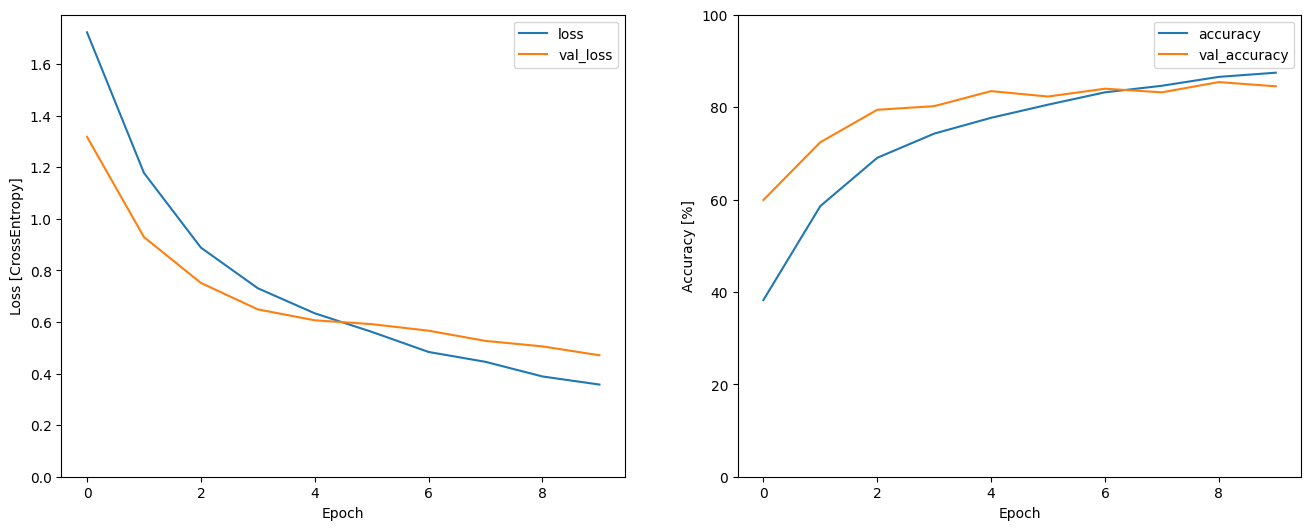

In [25]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [26]:
model.evaluate(test_spectrogram_ds, return_dict=True)

 1/13 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.7969 - loss: 0.5127

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8255 - loss: 0.5090  


{'accuracy': 0.832932710647583, 'loss': 0.5049060583114624}

### Display a confusion matrix

Use a [confusion matrix](https://developers.google.com/machine-learning/glossary#confusion-matrix) to check how well the model did classifying each of the commands in the test set:


In [27]:
y_pred = model.predict(test_spectrogram_ds)

 1/13 ━━━━━━━━━━━━━━━━━━━━ 3s 275ms/step

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


In [28]:
y_pred = tf.argmax(y_pred, axis=1)

In [29]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

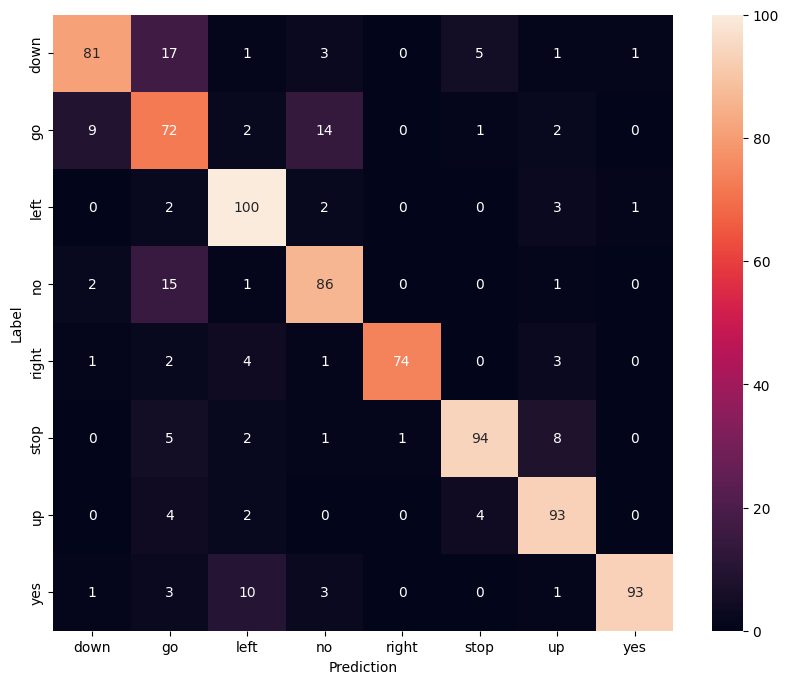

In [30]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "no". How well does your model perform?

W0000 00:00:1723794468.163578  244018 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723794468.181379  244018 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723794468.182527  244018 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723794468.183650  244018 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723794468.184778  244018 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723794468.185904  244018 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723794468.187040  244018 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723794468.188192  244018 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723794468.189325  244018 gp

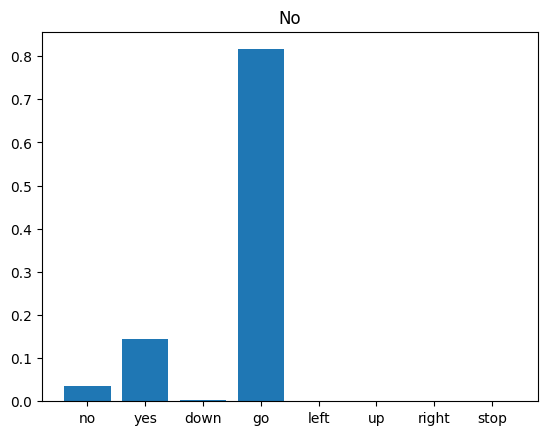

In [31]:
x = data_dir/'no/01bb6a2a_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['no', 'yes', 'down', 'go', 'left', 'up', 'right', 'stop']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=16000))

As the output suggests, your model should have recognized the audio command as "no".

## Export the model with preprocessing

The model's not very easy to use if you have to apply those preprocessing steps before passing data to the model for inference. So build an end-to-end version:

In [32]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch. 
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it. 
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]
    
    x = get_spectrogram(x)  
    result = self.model(x, training=False)
    
    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

Test run the "export" model:

In [33]:
export = ExportModel(model)
export(tf.constant(str(data_dir/'no/01bb6a2a_nohash_0.wav')))

{'predictions': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[ 1.0958828,  2.526922 , -1.8349309,  4.2553926, -4.2595496,
         -2.5386834, -3.6104631, -2.295511 ]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([3])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'no'], dtype=object)>}

Save and reload the model, the reloaded model gives identical output:

In [34]:
tf.saved_model.save(export, "saved")
imported = tf.saved_model.load("saved")
imported(waveform[tf.newaxis, :])

INFO:tensorflow:Assets written to: saved/assets


INFO:tensorflow:Assets written to: saved/assets


{'predictions': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[ 1.0958828,  2.526922 , -1.8349309,  4.2553926, -4.2595496,
         -2.5386834, -3.6104631, -2.295511 ]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([3])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'no'], dtype=object)>}

## Next steps

This tutorial demonstrated how to carry out simple audio classification/automatic speech recognition using a convolutional neural network with TensorFlow and Python. To learn more, consider the following resources:

- The [Sound classification with YAMNet](https://www.tensorflow.org/hub/tutorials/yamnet) tutorial shows how to use transfer learning for audio classification.
- The notebooks from [Kaggle's TensorFlow speech recognition challenge](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/overview).
- The 
[TensorFlow.js - Audio recognition using transfer learning codelab](https://codelabs.developers.google.com/codelabs/tensorflowjs-audio-codelab/index.html#0) teaches how to build your own interactive web app for audio classification.
- [A tutorial on deep learning for music information retrieval](https://arxiv.org/abs/1709.04396) (Choi et al., 2017) on arXiv.
- TensorFlow also has additional support for [audio data preparation and augmentation](https://www.tensorflow.org/io/tutorials/audio) to help with your own audio-based projects.
- Consider using the [librosa](https://librosa.org/) library for music and audio analysis.